In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
import glob
import json

from tqdm import tqdm
import tensorflow as tf

import pickle

In [2]:
from scripts.QLKNN import QLKNN, QLKNNDataset, QLKNN_Big
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
f = open("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_loss_epoch_vs_step_chart_data")
test_loss = json.load(f)
f.close()

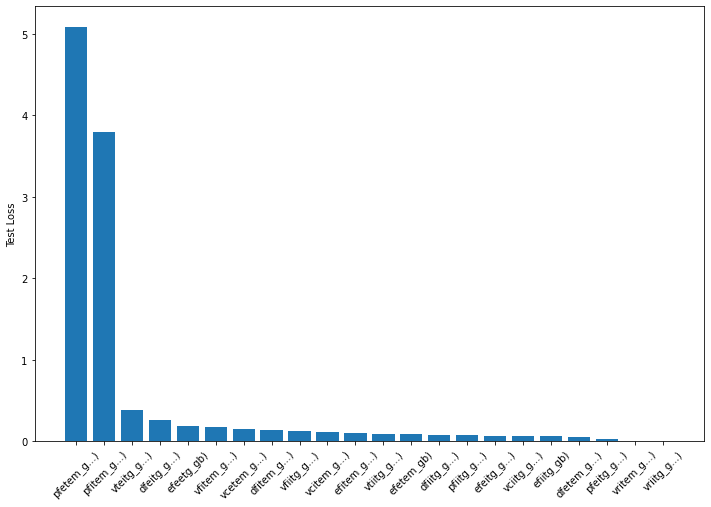

In [4]:
labels = []
out = []
for test in test_loss:
    experiment_name = test['name']
    x = experiment_name.split('-')
    labels.append(x[-1])
    out.append(test['y'][0])

x_points = np.arange(len(labels))

out = np.array(out)
sort_idx = np.argsort(np.array(out))[::-1]


out = out[sort_idx]

labels = np.array(labels)
labels = labels[sort_idx]

plt.figure(figsize = (12,8))
plt.bar(x_points, out)
plt.xticks(x_points, labels);
plt.xticks(rotation = 45);
plt.ylabel("Test Loss");

In [8]:
test_data_path = "../../data/valid_data_clipped.pkl"
train_data_path = "../../data/train_data_clipped.pkl"

df_train = pd.read_pickle(train_data_path)
df_train, scaler = ScaleData(df_train.sample(100_000))

df_test = pd.read_pickle(test_data_path)
df_test, scaler = ScaleData(df_test.sample(10_000), scaler)

dfeitg_gb_div_efiitg_gb


10it [00:06,  1.48it/s]


dfetem_gb_div_efetem_gb


10it [00:07,  1.33it/s]


dfiitg_gb_div_efiitg_gb


10it [00:08,  1.18it/s]


dfitem_gb_div_efetem_gb


10it [00:08,  1.24it/s]


efeetg_gb


10it [00:07,  1.27it/s]


efeitg_gb_div_efiitg_gb


10it [00:08,  1.25it/s]


efetem_gb


10it [00:07,  1.34it/s]


efiitg_gb


10it [00:07,  1.42it/s]


efitem_gb_div_efetem_gb


10it [00:06,  1.62it/s]


pfeitg_gb_div_efiitg_gb


10it [00:05,  1.68it/s]


pfetem_gb_div_efetem_gb


10it [00:05,  1.69it/s]


pfiitg_gb_div_efiitg_gb


10it [00:05,  1.68it/s]


pfitem_gb_div_efetem_gb


10it [00:03,  2.53it/s]


vceitg_gb_div_efiitg_gb


10it [00:05,  1.81it/s]


vcetem_gb_div_efetem_gb


10it [00:05,  1.69it/s]


vciitg_gb_div_efiitg_gb


10it [00:07,  1.37it/s]


vcitem_gb_div_efetem_gb


10it [00:06,  1.47it/s]


vfiitg_gb_div_efiitg_gb


10it [00:06,  1.54it/s]


vfitem_gb_div_efetem_gb


10it [00:06,  1.66it/s]


vriitg_gb_div_efiitg_gb


10it [00:04,  2.40it/s]


vritem_gb_div_efetem_gb


10it [00:07,  1.27it/s]
/var/tmp/ipykernel_29323/2042496601.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


vteitg_gb_div_efiitg_gb


10it [00:06,  1.62it/s]


vtiitg_gb_div_efiitg_gb


10it [00:06,  1.48it/s]


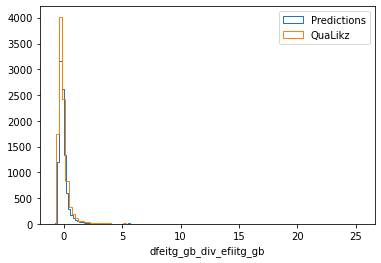

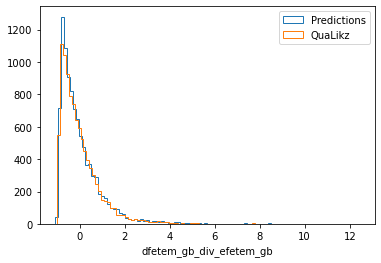

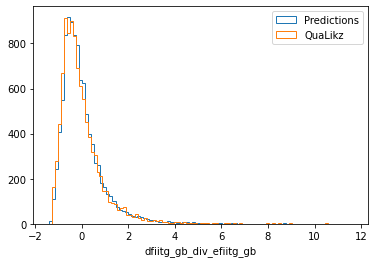

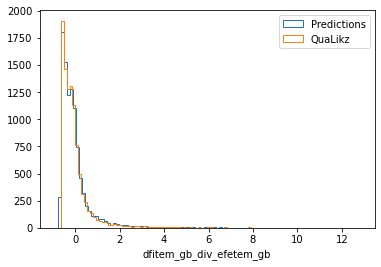

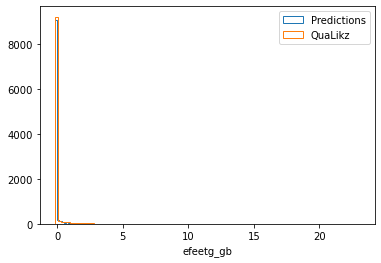

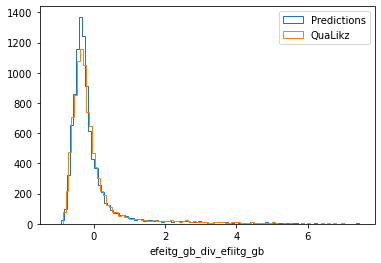

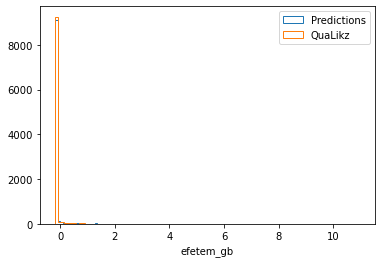

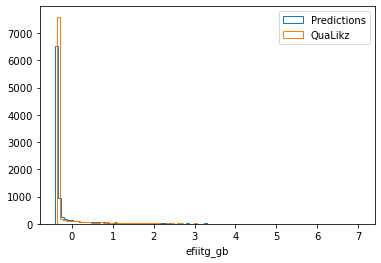

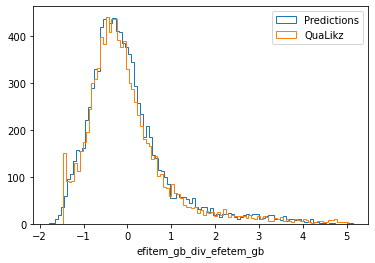

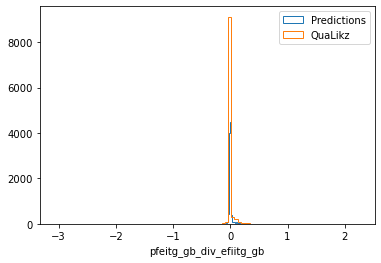

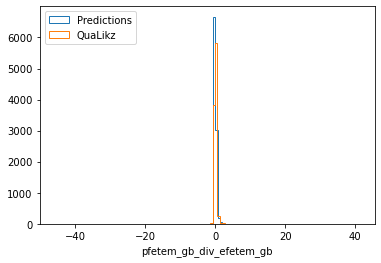

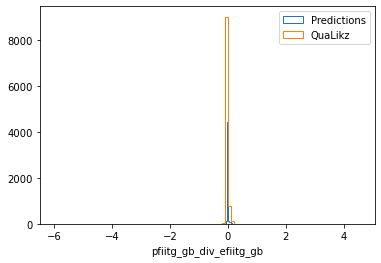

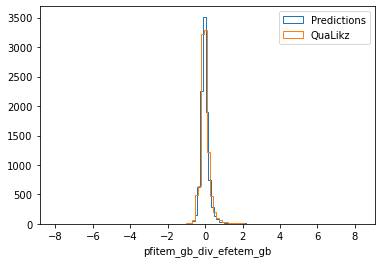

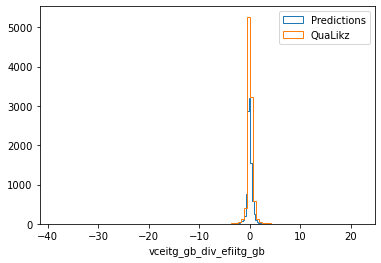

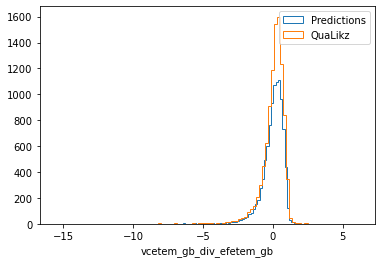

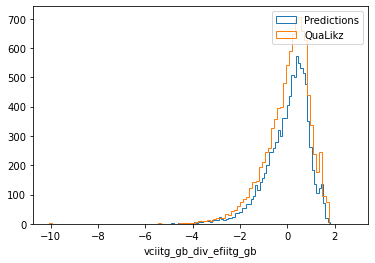

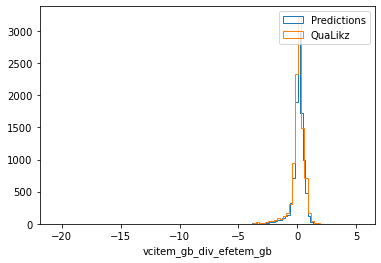

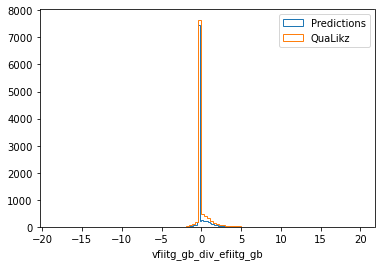

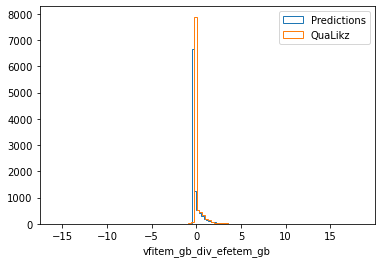

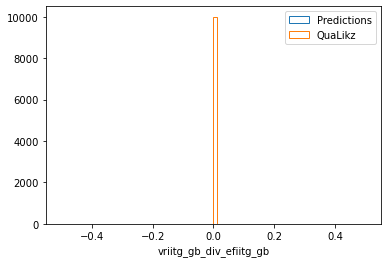

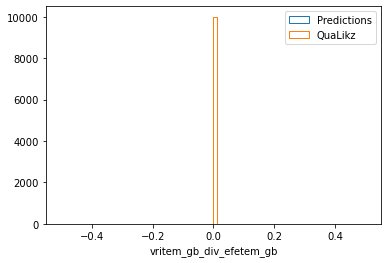

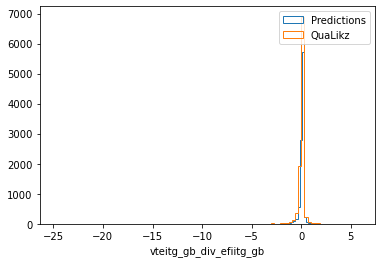

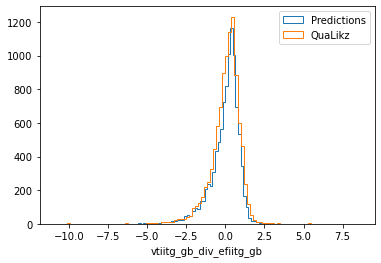

In [45]:
#test_data_path = "../../data/QLKNN_test_data.pkl"
test_data_path = "../../data/test_data_clipped.pkl"
train_data_path = "../../data/train_data_clipped.pkl"
predictions_list = []

for target in target_keys:
    print(target)
    path = glob.glob(f"../../logs/QLKNN-Regressor/Run-8-{target}/*.ckpt")[0]
    model = QLKNN_Big.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 25, learning_rate = 0.002)
    
    train_data = QLKNNDataset(train_data_path, columns = train_keys + [target], train = True)
    train_data.scale()

    test_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = False)
    test_data.data = test_data.data.sample(10_000)
    test_data.scale()

    test_loader = DataLoader(test_data, batch_size = 1000, shuffle = False, num_workers = 1)
    
    tmp = []
    for step, (x, y) in tqdm(enumerate(test_loader)):
        predictions = model(x).detach().numpy()
        tmp.append(predictions)
    
    flattened_predictions = np.array(tmp).flatten()
    predictions_list.append(flattened_predictions)
    
    plt.figure()
    
    plt.hist(flattened_predictions, bins = 100, histtype = 'step',
             label = "Predictions",)# range = (predictions.min(), 6))
    plt.hist(test_data.data[target], bins = 100, histtype = 'step',
             label = "QuaLikz",)# range = (predictions.min(), 6))
    
    plt.xlabel(target)
    plt.legend()
    

In [ ]:
predictions_numpy = predictions.squeeze()

random_variable = test_data.data[train_keys[3]].to_numpy()

predictions_dict = {'x': random_variable, 'y': predictions_numpy}
predictions_df = pd.DataFrame(data = predictions_dict)
predictions_df['type'] = 'QLKNN'

target_dict = {'x': random_variable, 'y': test_data.data[target]}
target_df = pd.DataFrame(data = target_dict)
target_df['type'] = 'target'

plot_df = pd.concat([predictions_df.sample(5_000), target_df.sample(5_000)], axis = 0, ignore_index = True)

plot_df

In [ ]:
sns.jointplot(data = plot_df, x = 'x', y = 'y', hue = 'type', kind = 'kde')

In [12]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

0.17468671039338562
0.16344663901555787
-9.336335297253957e-17
1.0000812446684522


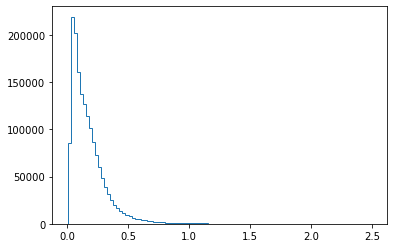

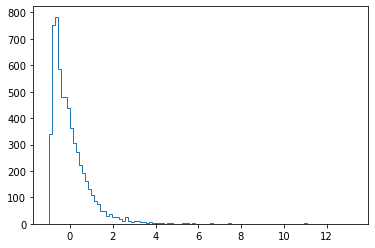

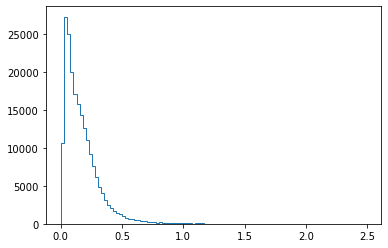

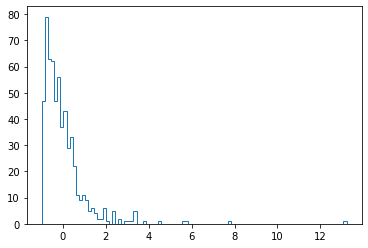

In [15]:
#test_data_path = "../../data/QLKNN_test_data.pkl"
test_data_path = "../../data/valid_data_clipped.pkl"
train_data_path = "../../data/train_data_clipped.pkl"

df_train = pd.read_pickle(train_data_path)
plt.figure()
plt.hist(df_train["dfetem_gb_div_efetem_gb"], bins = 100, histtype = "step");
print(df_train["dfetem_gb_div_efetem_gb"].mean())
print(df_train["dfetem_gb_div_efetem_gb"].std())
df_train, scaler = ScaleData(df_train.sample(100_000))
plt.figure()
plt.hist(df_train["dfetem_gb_div_efetem_gb"], bins = 100, histtype = "step");
print(df_train["dfetem_gb_div_efetem_gb"].mean())
print(df_train["dfetem_gb_div_efetem_gb"].std())

n = 10_000
df_test = pd.read_pickle(test_data_path)
plt.figure()
plt.hist(df_test["dfetem_gb_div_efetem_gb"], bins = 100, histtype = "step");
df_test, _ = ScaleData(df_test.sample(n), scaler)
plt.figure()
plt.hist(df_test["dfetem_gb_div_efetem_gb"], bins = 100, histtype = "step");

In [17]:
dir(train_data)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'data',
 'functions',
 'register_datapipe_as_function',
 'register_function',
 'scale',
 'scaler']

In [13]:
keys = []

target_dict = {}

for target in target_keys:
    print(f"Evaluating on {target}")
    path = glob.glob(f"../../logs/QLKNN-Regressor/Run-8-{target}/*.ckpt")[0]
    model = QLKNN_Big.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 25, learning_rate = 0.002)
    
    train_data = QLKNNDataset(train_data_path, columns = train_keys + [target], train = True)
    train_data.scale()

    test_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = False)
    test_data.data = test_data.data.sample(100_000)
    used_idx = test_data.data.index.tolist()
    test_data.scale()
    
    test_loader = DataLoader(test_data, batch_size = 10_000, shuffle = False, num_workers = 0)
    
    eval_model = model.eval()
    enable_dropout(eval_model)


#     tmp_list = []
#     tmp_tmp = []
#     for step, (x, y) in tqdm(enumerate(test_loader)):
#         step_list = []
#         for _ in range(100):
#             predictions = eval_model(x).detach().numpy()
#             step_list.append(predictions)
#             tmp_tmp.append(eval_model(X[0]).detach().numpy().flatten())
        
#         step_list_flatten = np.array(step_list).flatten()
        
    runs = []    
    hist_list = []
    for _ in tqdm(range(100)):
        step_list = []
        for step, (x, y) in enumerate(test_loader):
            predictions = eval_model(x).detach().numpy()
            step_list.append(predictions)
            
        flattened_predictions = np.array(step_list).flatten()
        runs.append(flattened_predictions)
        hist_list.append(flattened_predictions[0])
            
#     for _ in tqdm(range(100)):
#         output = eval_model(X)
#         tmp_list.append(output)
#         tmp_tmp.append(eval_model(X[0]).detach().numpy().flatten())
       
    plt.figure()
    plt.hist(hist_list, bins = 10);
    
    output_mean = np.mean(np.array(runs), axis = 0)

    out_std = np.std(np.array(runs), axis = 0)
    
    params = {"indices": used_idx, "means": output_mean, "std": out_std}
    
    target_dict[target] = params  

Evaluating on dfeitg_gb_div_efiitg_gb


 10%|█         | 10/100 [05:35<50:18, 33.54s/it]


KeyboardInterrupt: 

In [60]:
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(target_dict, f)

In [7]:
with open('saved_dictionary.pkl', 'rb') as f:
    target_dict = pickle.load(f)

In [9]:
target = 'efiitg_gb'

train_data = QLKNNDataset(train_data_path, columns = train_keys + [target], train = True)
train_data.scale()

test_data = QLKNNDataset(test_data_path, columns = train_keys + [target], train = False)
test_data.data = test_data.data.loc[target_dict[target]['indices']]
test_data.scale()

Text(0.5, 0, 'efiitg_gb')

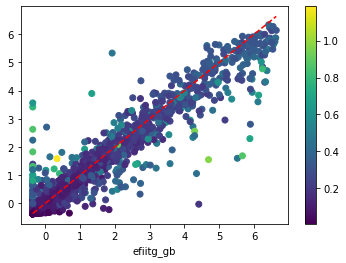

In [10]:
plt.figure()
x_ = np.linspace(test_data.data[target].min(), test_data.data[target].max(), 100)

plt.plot(x_, x_, "r--")
plt.scatter(test_data.data[target], target_dict[target]['means'], c = target_dict[target]['std'])
plt.colorbar()

#plt.xlim(0,10)
#plt.ylim(0,10)
plt.xlabel(target)

## Combined Regression and Classification Test

In [24]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")
df_train = train_data[train_keys + target_keys]
df_train, scaler = ScaleData(df_train.sample(100_000))

In [25]:
X_train = df_train[train_keys]
#y_train = df_train[['efeetg_gb', 'efetem_gb', 'efiitg_gb']]
y_train = df_train[target_keys[:10]]

In [71]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation = 'relu')
])

# classification = tf.keras.Sequential([
#     tf.keras.layers.Dense(15, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(15, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
# ])

# regression = tf.keras.Sequential([
#     tf.keras.layers.Dense(15, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(15, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
# ])

inputs = tf.keras.Input(shape = (15,))
#dense_out = dense(inputs)
dense1 = tf.keras.layers.Dense(128, activation = 'relu')(inputs)
dense_out = tf.keras.layers.Dense(128, activation = 'relu')(dense1)

#class_tmp = classification(dense_out)
class_tmp = tf.keras.layers.Dense(10, activation = 'sigmoid', name = "class")(dense_out)
#class_out = tf.keras.layers.Dense(10, activation = 'linear', name = "class_out",
#                                  use_bias = False, trainable = False,
#                                 kernel_initializer=tf.constant_initializer(1.))(class_tmp)

#regression_tmp = regression(dense_out)
regression_tmp = tf.keras.layers.Dense(10, activation = 'linear', name = "regression")(dense_out)
#regression_out = tf.keras.layers.Concatenate(axis = 1, name = "regression_out")([class_tmp, regression_tmp])

regression_out = tf.keras.layers.Concatenate(axis = 1, name = "regression_out")([class_tmp, regression_tmp])

In [35]:
def classification_loss(y_true, y_pred):
    
    mask = tf.math.is_nan(y_true)
    classes = tf.where(mask, tf.constant([0]), tf.constant([1]))
    #print(classes)
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
    loss = bce(classes, y_pred)
    return loss

def regression_loss(y_true, y_pred):
    #print(f"y predicted {y_pred}")
    loss = tf.constant([0.])
    #print(f"Initial loss {loss}")
    y_regression = y_pred[:,10:]
    y_class = y_pred[:,:10]
    
    #y_true_class = y_true[:,10:]
    #y_true_regression = y_true[:,:10]
    mask = tf.math.is_nan(y_true) #tf.where tf.gather

    true_NaNs = tf.boolean_mask(y_true, mask)
    class_NaNs = tf.boolean_mask(y_class, mask)
    regression_NaNs = tf.boolean_mask(y_regression, mask)
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
    print(true_NaNs)
    class_loss_tmp = bce(true_NaNs, class_NaNs)#tf.math.log(1 - class_NaNs)
    class_loss = tf.reshape(class_loss, (1,))
    
    #class_loss_tmp = tf.math.log(1 - class_NaNs)
    #class_loss_tmp2 = tf.reshape(tf.math.reduce_sum(class_loss_tmp), (1,))
    #class_loss = -5 * tf.cast((1 / len(class_NaNs)), tf.float32) * class_loss_tmp2
    #print(f"Class loss {class_loss}")
    
    loss = loss + 3 * class_loss
    
    true_not_NaNs = tf.boolean_mask(y_true, ~mask)
    class_not_NaNs = tf.boolean_mask(y_class, ~mask)
    regression_not_NaNs = tf.boolean_mask(y_regression, ~mask)
    
    mse = tf.keras.losses.MeanSquaredError()
    reg_loss = tf.reshape(mse(true_not_NaNs, regression_not_NaNs), (1,))
    #print(f"Regression loss {reg_loss}")
    
    loss = loss + reg_loss
    #print(loss)
    return loss

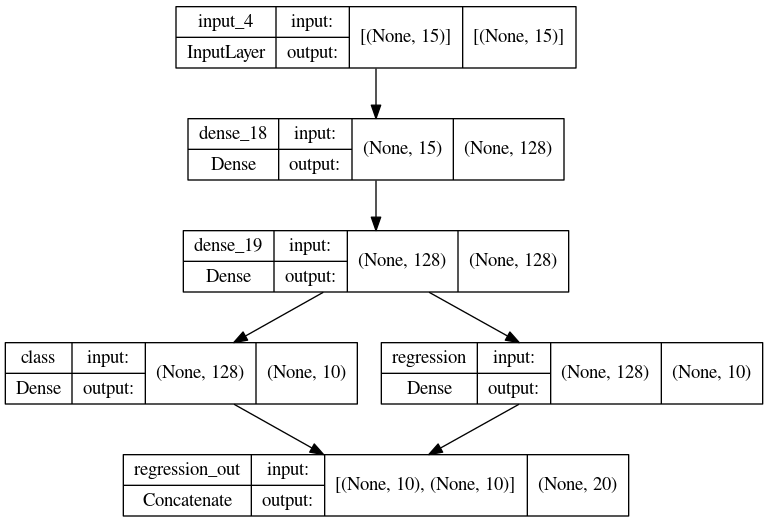

In [72]:
# model = tf.keras.Model(inputs = inputs, outputs = [class_out, regression_out])

# model.compile(
#     optimizer = 'adam',
#     loss = [
#         classification_loss,
#         regression_loss,
#     ],
#     loss_weights=[1.0, 1.0],
#     run_eagerly=True
# )

model = tf.keras.Model(inputs = inputs, outputs = regression_out)

model.compile(
    optimizer = 'adam',
    loss = regression_loss,
    run_eagerly=True
)

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# inp = model.input
# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [tf.keras.backend.function([inp, tf.keras.backend.learning_phase()], [out]) for out in outputs]

# # Testing
# test = np.random.random(input_shape)[np.newaxis,...]
# layer_outs = [func([test, 1.]) for func in functors]
# print(layer_out)

In [73]:
y_train_class = np.where(np.isnan(y_train.values), 0, 1)
#y = np.concatenate((y_train.values, y_train_class), axis = 1)

model.fit(X_train, y_train, batch_size = 2048, epochs = 100)

Epoch 1/100
49/49 [==============================] - 2s 42ms/step - loss: 2.1805
Epoch 2/100
49/49 [==============================] - 2s 39ms/step - loss: 0.8446
Epoch 3/100
49/49 [==============================] - 2s 40ms/step - loss: 0.7743
Epoch 4/100
49/49 [==============================] - 2s 40ms/step - loss: 0.7308
Epoch 5/100
49/49 [==============================] - 2s 40ms/step - loss: 0.7012
Epoch 6/100
49/49 [==============================] - 2s 40ms/step - loss: 0.6762
Epoch 7/100
49/49 [==============================] - 2s 40ms/step - loss: 0.6540
Epoch 8/100
49/49 [==============================] - 2s 40ms/step - loss: 0.6404
Epoch 9/100
49/49 [==============================] - 2s 40ms/step - loss: 0.6167
Epoch 10/100
49/49 [==============================] - 2s 40ms/step - loss: 0.6016
Epoch 11/100
49/49 [==============================] - 2s 40ms/step - loss: 0.5840
Epoch 12/100
49/49 [==============================] - 2s 40ms/step - loss: 0.5684
Epoch 13/100
49/49 [=====

In [74]:
outputs = model.predict(X_train.values)

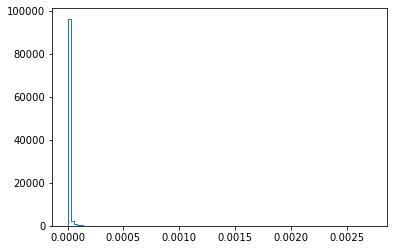

In [76]:
plt.figure()
plt.hist(outputs[:,3], bins = 100, histtype = 'step');

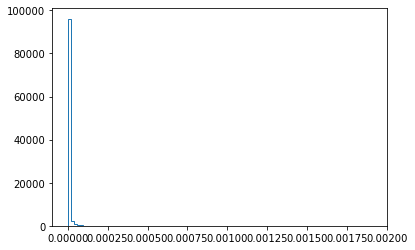

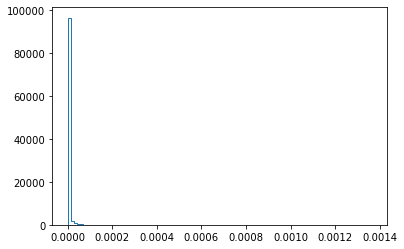

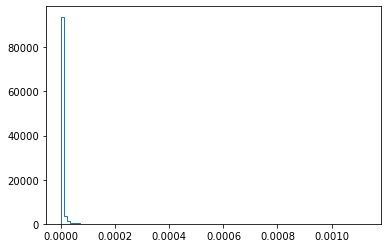

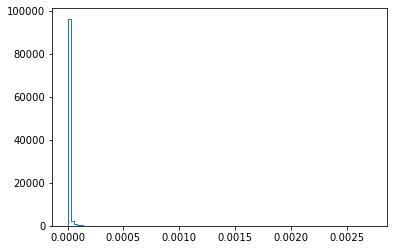

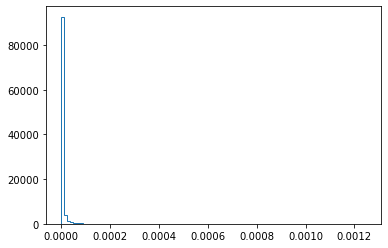

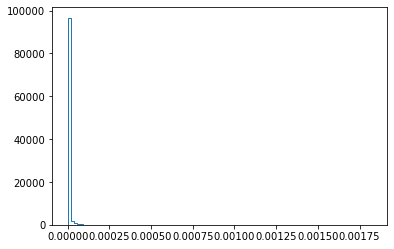

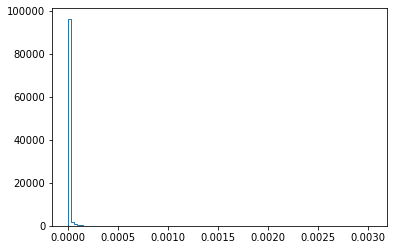

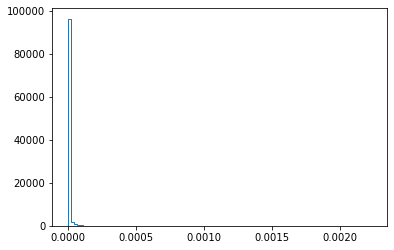

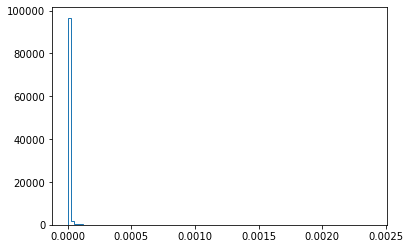

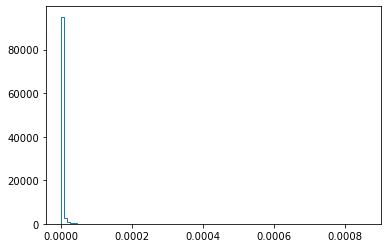

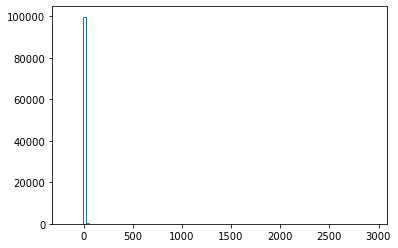

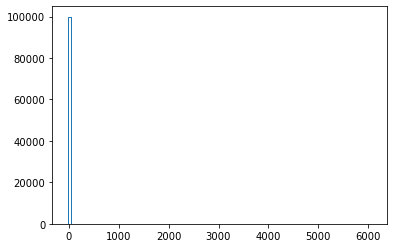

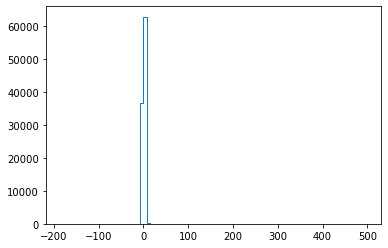

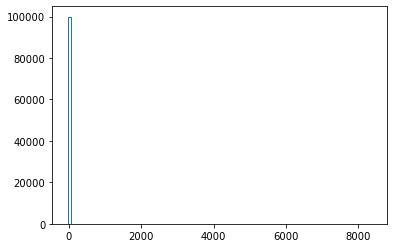

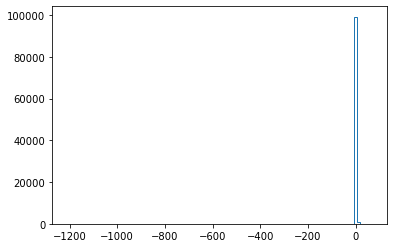

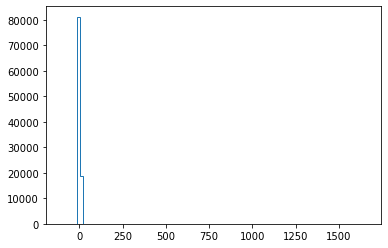

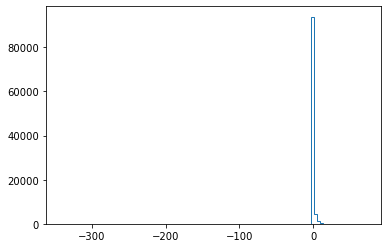

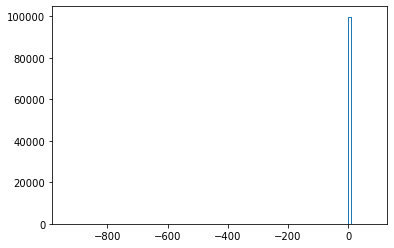

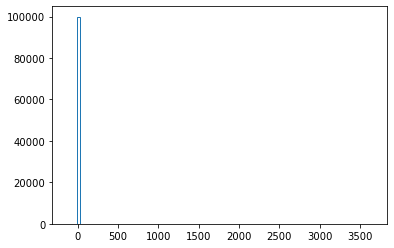

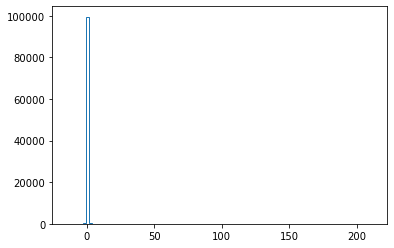

In [79]:
for i in range(20):
    plt.figure()
    
    plt.hist(outputs[:,i], bins = 100, histtype = 'step');

### MSE Against Number of Data Points

In [6]:
SIZES = [
    1_000,
    2_000,
    5_000,
    10_000,
    20_000,
    50_000,
    100_000,
    1_000_000,
    10_000_000,
]

leading_fluxes = ["efeetg_gb", "efetem_gb", "efiitg_gb"]

Text(0, 0.5, 'Validation MSE')

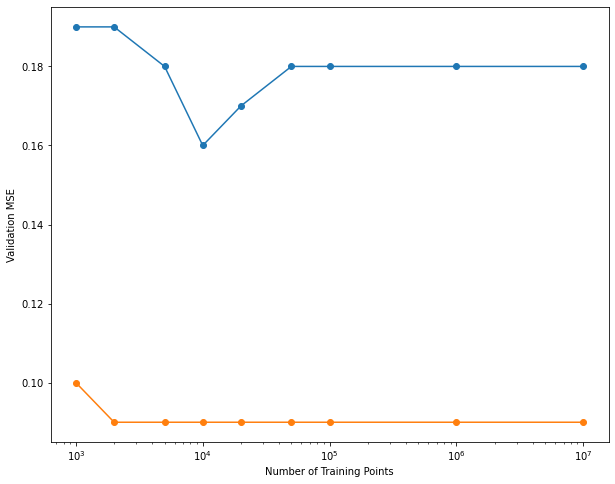

In [62]:
MSE_list_1 = []
MSE_list_2 = []
for size in SIZES:
    path_1 = glob.glob(f"/share/rcifdata/jbarr/UKAEAGroupProject/logs/MSE/{leading_fluxes[0]}-{size}-*")[-1]
    val_loss_1 = float(path_1.split("=")[-1].split(".ckpt")[0])
    MSE_list_1.append(val_loss_1)
    
    path_2 = glob.glob(f"/share/rcifdata/jbarr/UKAEAGroupProject/logs/MSE/{leading_fluxes[1]}-{size}-*")[-1]
    val_loss_2 = float(path_2.split("=")[-1].split(".ckpt")[0])
    MSE_list_2.append(val_loss_2)
    
plt.figure(figsize = (10,8))
plt.plot(SIZES, MSE_list_1, "-o", label = "efeetg_gb")
plt.plot(SIZES, MSE_list_2, "-o", label = "efetem_gb")
plt.xscale("log")
plt.xlabel("Number of Training Points")
plt.ylabel("Validation MSE")

In [ ]:
import comet_ml
import torch
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.callbacks import TQDMProgressBar, EarlyStopping, ModelCheckpoint

from scripts.QLKNN import QLKNN, QLKNN_Big, QLKNNDataset
from scripts.utils import train_keys, target_keys, prepare_model, callbacks
import copy


TRAIN_PATH = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
VAL_PATH = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"

SIZES = [
    100,
    200,
    300,
    400,
    500,
    1000,
]

PARAMS = {
    "epochs": 25,
    "learning_rate": 0.001,
}

accelerator = "gpu"
num_gpu = 3

leading_fluxes = ["efeetg_gb", "efetem_gb", "efiitg_gb"]

for flux in leading_fluxes:
    keys = train_keys + [flux]
    train_data, val_data = prepare_model(TRAIN_PATH, VAL_PATH, QLKNNDataset, keys)

    for size in SIZES:
        print(f"Training model for {flux} with {size} training points")
        experiment_name = f"{flux}-{size}"
        train_data_size = copy.deepcopy(train_data)
        train_data_size.data = train_data_size.data.sample(size)

        batch_size = size if size <= 10_000 else 4096
        patience = 25 if size <= 10_000 else 5

        model = QLKNN_Big(n_input=15, **PARAMS, batch_size=batch_size)

        train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=10,
        )

        val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=10,
        )

        progress = TQDMProgressBar(refresh_rate=250)

        early_stop_callback = EarlyStopping(
            monitor="val_loss", min_delta=0.0, patience=patience
        )


        trainer = Trainer(
            max_epochs=PARAMS["epochs"],
            accelerator=accelerator,
            strategy=DDPPlugin(find_unused_parameters=False),
            devices=num_gpu,
            callbacks=[early_stop_callback, progress],
            log_every_n_steps=250,
            benchmark=True,
            check_val_every_n_epoch=2,
        )

        trainer.fit(model, train_loader, val_loader)

Training model for efeetg_gb with 100 training points


/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Traceback (most recent call last):
  File "/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/home/jbarr/.conda/envs/UKAEA/lib/python3.9/site-packages/t